In [1]:
# This notebook develops an algorithm to optimize the epochs of a given node
# in the end it is tested

In [2]:
from orbit import Orbit, AU2km, mu, day2s
import elements as el
import angles as an

from util import asteroids, earth, asteroid_ind
from util import select_asteroid

from node import Node

import lambert_combine as lb
#from lambert_izzo import lambert as lambert_izzo
#from lambert import lambert as lambert_bate

import sys

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import logging
from scipy.optimize import minimize, LinearConstraint

import random

# Create optimizer

Define the russian solution in `t_list`

A slightly modified solution in `t_list_mod` (to test the optimiser)

`ind_list` is the solution by the russians

In [3]:
ind_list = [-1, 1057, 1125, 1328, 1181, 937,1077, 1289, 1000, 601, 1376]


t_list = np.array([58676.40, 58731.65, 58801.45, 58866.95, 58973.95, 59084.55, 59119.45, 59221.75,59326.95, 59366.25,59419.55])

#sort is there just in case some epochs flip
dt = 20 # max this many days away from optimal solution
t_list_mod = np.array([t + 2*dt*random.random()-dt for t in t_list])
t_list_mod.sort()


In [4]:
t_list_mod-t_list

array([ -2.97213456, -15.6887884 ,   8.88447822,  -5.64790821,
        10.51845898,  -4.11418588,   5.14889692, -15.34784113,
        -6.41380721, -19.7484294 ,   8.22302094])

In [5]:
def create_node_from_list(t_list, ind_list):
    
    # function returns the final node, given a list of times and asteroids to hit
    
    # create the initial orbit:
    initial = Orbit(name='initial', index=ind_list[0])
    rv = select_asteroid(ind_list[0]).rv(t_list[0])
    initial.from_rv(t_list[0], *rv)
    
    # create the initial node:
    node = Node(t_list[0], index=ind_list[0], approach_orbit=initial, parent=None)
    
    # create all the legs:
    for t, ind in zip(t_list[1:],ind_list[1:]):
        node = node.create_next_node(target_ind = ind, target_epoch=t)
        
    return node


    
    

In [6]:
node_original = create_node_from_list(t_list, ind_list)
node_mod = create_node_from_list(t_list_mod, ind_list)


/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/lambert_combine.py:145: RuntimeWarning: invalid value encountered in power
  residue = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/lambert_combine.py:145: RuntimeWarning: invalid value encountered in sqrt
  residue = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/lambert_combine.py:150: RuntimeWarning: invalid value encountered in power
  Fdot = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 1.5) * (((1/(2*z)) * (_Stumpff_C(z) - 3*_Stumpff_S(z)/(2*_Stumpff_C(z)))) + 3*np.power(_Stumpff_S(z),2)/(4*_Stumpff_C(z))) + (A/8)*(3*_Stumpff_S(z)*np.sqrt(_y_538(r1,r2,A,z))/_Stumpff_C(z) + A*np.sqrt(_Stumpff_C(z)/_y_538(r1,r2,A,z)))
/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/lambert_co

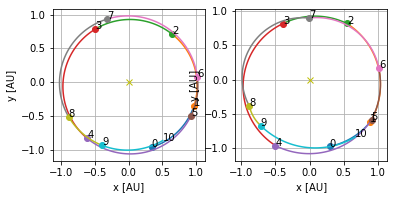

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2)
node_original.plot(only_traj=True, ax=ax1)
node_mod.plot(only_traj=True, ax=ax2)

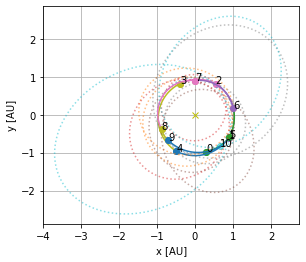

In [8]:
node_mod.plot()

In [9]:
def create_constraint(t_list):
    A1=np.diagflat(-np.ones(len(t_list)), k=0)
    A2=np.diagflat(+np.ones(len(t_list)-1), k=1)
    A=(A1+A2)[:-1,:]
    return LinearConstraint(A, 0, np.inf, keep_feasible=True)

In [10]:
lin_con = create_constraint(t_list)

In [11]:
def path_cost_epochs(epochs, inds):
    # return the total delta v for the sequence of asteroid ind at time t
    # works by creating the node first, and then querying the cost
    
    #sanity checks
    assert len(epochs) == len(inds), "len(t) must be the same as len(ind)"
    
    node = create_node_from_list(t_list=epochs, ind_list=inds)
    
    return node.cost

In [12]:
path_cost_epochs(t_list, ind_list)

3.4754249163792594

In [13]:
path_cost_epochs(t_list_mod, ind_list)

46.68640377787084

In [14]:
# pretty big diff!

In [15]:
# optimize over +/-50 days?
dt=50
sol=minimize(path_cost_epochs,t_list_mod, args=(ind_list), method=None, jac=None, hess=None, hessp=None, bounds=[(t-dt, t+dt) for t in t_list], constraints=(lin_con), tol=None, callback=None, options=None)
sol

/Users/Devansh/anaconda3/lib/python3.6/site-packages/scipy/optimize/_constraints.py:342: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  "method.", OptimizeWarning)


     fun: 3.3594954722810737
     jac: array([ 1.06006861e-04,  4.38272953e-04,  1.79952383e-03,  5.21776080e-03,
        4.61968780e-03, -2.67952681e-04, -1.43429637e-03,  8.09520483e-04,
       -2.19137609e-01,  2.32846141e-02, -6.56723976e-04])
 message: 'Optimization terminated successfully.'
    nfev: 708
     nit: 53
    njev: 53
  status: 0
 success: True
       x: array([58676.18716297, 58731.89392755, 58801.24247461, 58867.08447816,
       58974.06816112, 59084.47078326, 59119.27103054, 59222.43392404,
       59326.85294838, 59365.91582343, 59419.14357857])

In [16]:
sol.x-t_list_mod

array([  2.75929753,  15.93271595,  -9.09200361,   5.78238637,
       -10.40029786,   4.03496915,  -5.32786639,  16.03176517,
         6.31675559,  19.41425284,  -8.62944238])

In [17]:
sol.x-t_list

array([-0.21283703,  0.24392755, -0.20752539,  0.13447816,  0.11816112,
       -0.07921674, -0.17896946,  0.68392404, -0.09705162, -0.33417657,
       -0.40642143])

In [18]:
# now create a new node based on this info

node_opt = create_node_from_list(t_list=sol.x, ind_list=ind_list)

In [19]:
node_opt

MJD 59419.14,   1376,    '2008PK3',

In [20]:
def get_ind_list(node):
    
    if node.parent_node is None:
        return [node.index]
    
    return  get_ind_list(node.parent_node)+ [node.index]

def get_epoch_list(node):
    
    if node.parent_node is None:
        return [node.epoch]
    
    return  get_epoch_list(node.parent_node)+ [node.epoch]
    

In [21]:
print(node_opt.history())

Epoch,         Index,    Name,

MJD 58676.19,     -1,    Earth,
MJD 58731.89,   1057,    '2006QV89',
MJD 58801.24,   1125,    '2006XP4',
MJD 58867.08,   1328,    '2008EP6',
MJD 58974.07,   1181,    '2007KV2',
MJD 59084.47,    937,    '2005XN27',
MJD 59119.27,   1077,    '2006TB7',
MJD 59222.43,   1289,    '2008AF4',
MJD 59326.85,   1000,    '2006HF6',
MJD 59365.92,    601,    '2003LW2',
MJD 59419.14,   1376,    '2008PK3',


In [22]:
get_ind_list(node_opt)

[-1, 1057, 1125, 1328, 1181, 937, 1077, 1289, 1000, 601, 1376]

In [23]:
get_epoch_list(node_opt)

[58676.18716296791,
 58731.89392754931,
 58801.242474609906,
 58867.08447816347,
 58974.068161124,
 59084.47078326331,
 59119.27103053941,
 59222.43392403546,
 59326.85294837971,
 59365.915823434865,
 59419.14357856781]

# lets test the implementation within the class definition

Modified, cost: 46.68640378 km/s


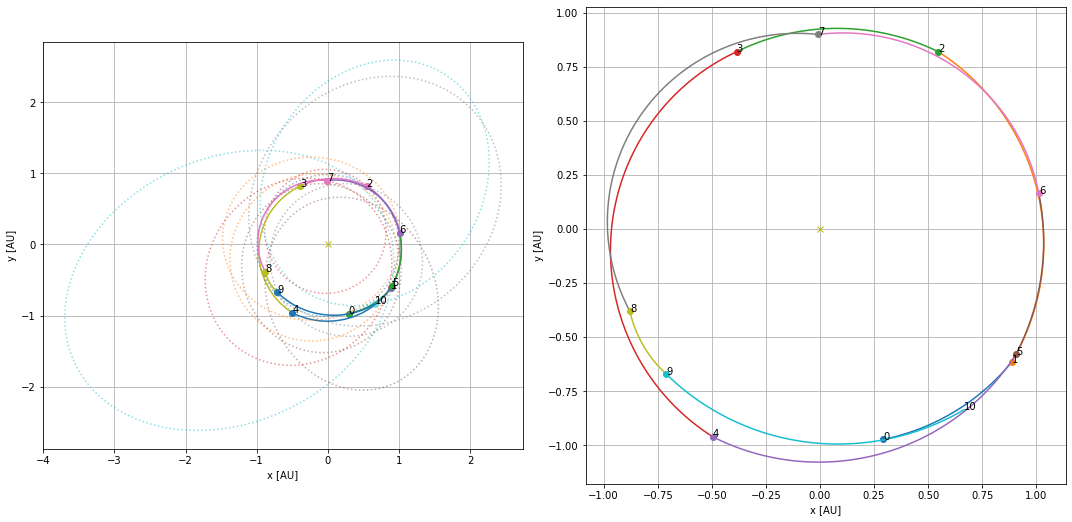

In [24]:
# plot the russian sol with modifications
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
node_mod.plot(ax=ax1)
node_mod.plot(only_traj=True,ax=ax2)
plt.tight_layout()
print(f'Modified, cost: {node_mod.cost:4.8f} km/s')

In [25]:
# now perform the same optimization except by calling the class
node_new_opt = node_mod.local_opt()


Optimized, cost: 3.35949547 km/s


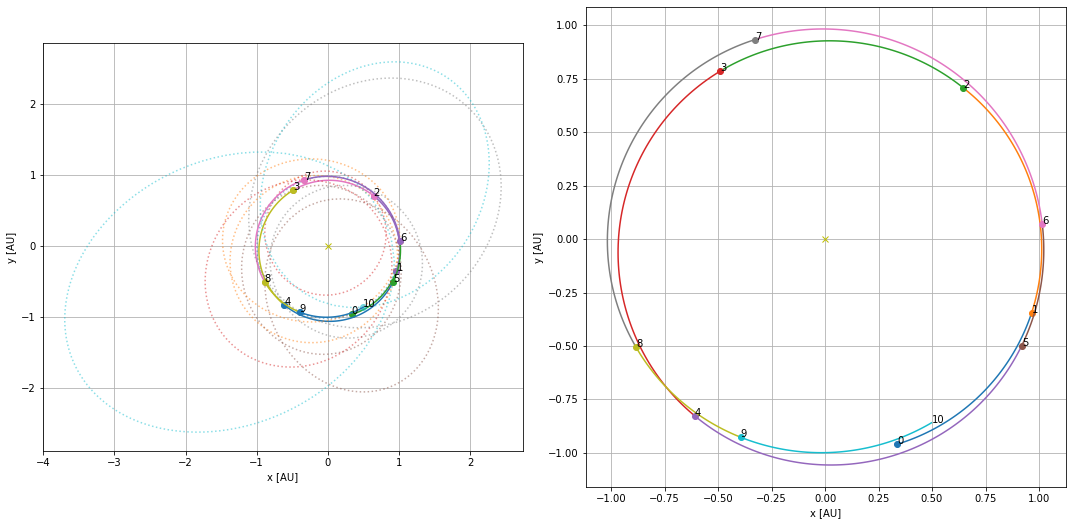

In [26]:
# plot the optimized solution
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
node_new_opt.plot(ax=ax1)
node_new_opt.plot(only_traj=True, ax=ax2)
plt.tight_layout()
print(f'Optimized, cost: {node_new_opt.cost:4.8f} km/s')

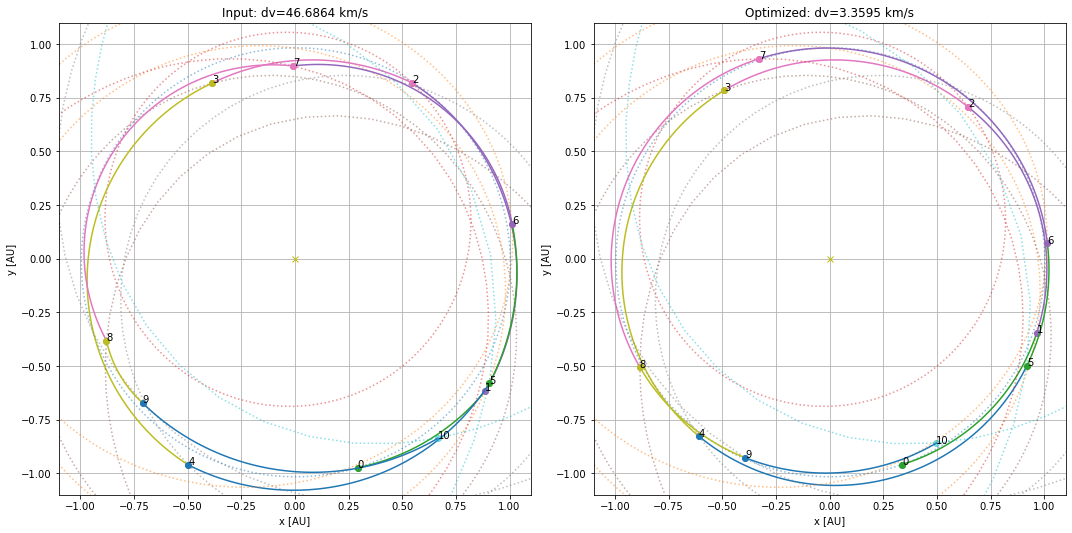

In [27]:
# compare the two
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
node_mod.plot(only_traj=False,ax=ax1)
ax1.set_title(f'Input: dv={node_mod.cost:4.4f} km/s')
node_new_opt.plot(only_traj=False, ax=ax2)
ax2.set_title(f'Optimized: dv={node_new_opt.cost:4.4f} km/s')
ax1.set_ylim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])
ax1.set_xlim([-1.1, 1.1])
ax2.set_xlim([-1.1, 1.1])
plt.tight_layout()


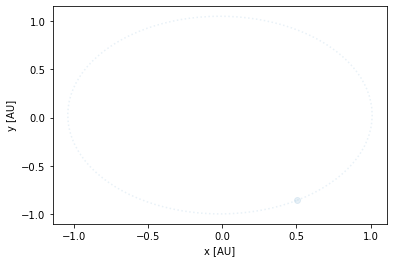

In [28]:
kwargs = {'alpha':0.1,'linestyle':':'}
node_original.approach_orbit.plot(**kwargs)